In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [23]:
# Step 1: 데이터 다운로드
tickers = ['SPY', 'IEV', 'EEM', 'TLT', 'GLD']  # 선택된 ETF
start_date = '2007-01-05'
end_date = '2024-11-10'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
risk_free_rate = 0.03

[*********************100%***********************]  5 of 5 completed


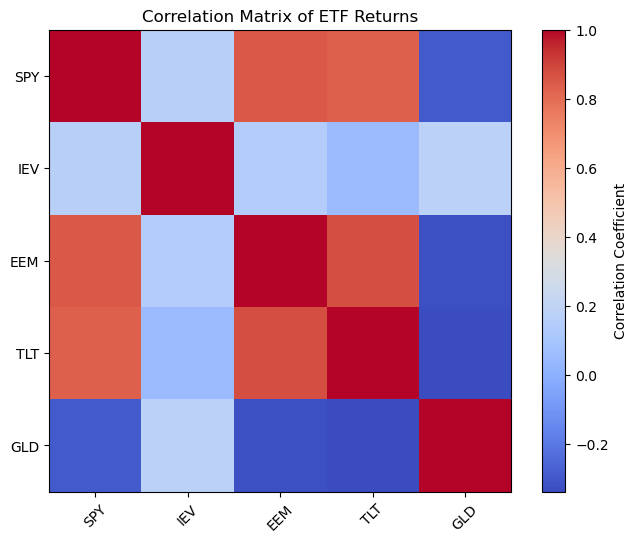

In [24]:
# Step 1-1: 수익률 상관계수 행렬 시각화
correlation_matrix = returns.corr()
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.title("Correlation Matrix of ETF Returns")
plt.xticks(range(len(tickers)), tickers, rotation=45)
plt.yticks(range(len(tickers)), tickers)
plt.show()

In [25]:
# 포트폴리오 성능 계산 함수
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (returns - risk_free_rate) / std
    return returns, std, sharpe

In [36]:
# 효율적 프론티어의 포트폴리오 비중 계산 함수
def get_efficient_weights(target_return, mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # 비중 합은 1
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}  # 기대수익률 제약
    ]
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets]
    result = minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x


In [37]:
# 최소분산 포트폴리오 함수
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[1]


In [38]:
# Step 1-3: 효율적 프론티어 각 기대수익률에 따른 자산별 비중 추이
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_weights = [get_efficient_weights(r, mean_returns, cov_matrix) for r in target_returns]

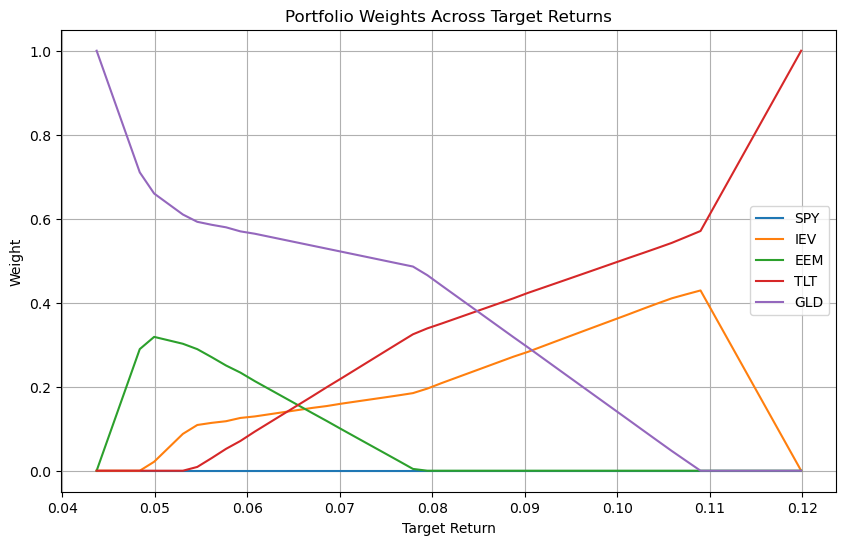

In [39]:
# Step 1-3: 효율적 프론티어 각 기대수익률에 따른 자산별 비중 추이
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_weights = [get_efficient_weights(r, mean_returns, cov_matrix) for r in target_returns]

# 비중 변화 시각화
plt.figure(figsize=(10, 6))
for i, ticker in enumerate(tickers):
    plt.plot(target_returns, [w[i] for w in efficient_weights], label=ticker)
plt.title('Portfolio Weights Across Target Returns')
plt.xlabel('Target Return')
plt.ylabel('Weight')
plt.legend()
plt.grid()
plt.show()

In [27]:
# 최대샤프 포트폴리오 (1-2, 3)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

result_max_sharpe = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = result_max_sharpe.x

In [29]:
# Risk Parity 계산 (4)
def risk_parity_weights(cov_matrix):
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / inv_vol.sum()
    return weights

risk_parity_weights = risk_parity_weights(cov_matrix)

In [30]:
# 최대 분산비율 (5)
def diversification_ratio(weights, cov_matrix):
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    asset_vols = np.sqrt(np.diag(cov_matrix))
    return -np.sum(weights * asset_vols) / portfolio_vol

result_md = minimize(diversification_ratio, initial_weights, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
max_div_weights = result_md.x

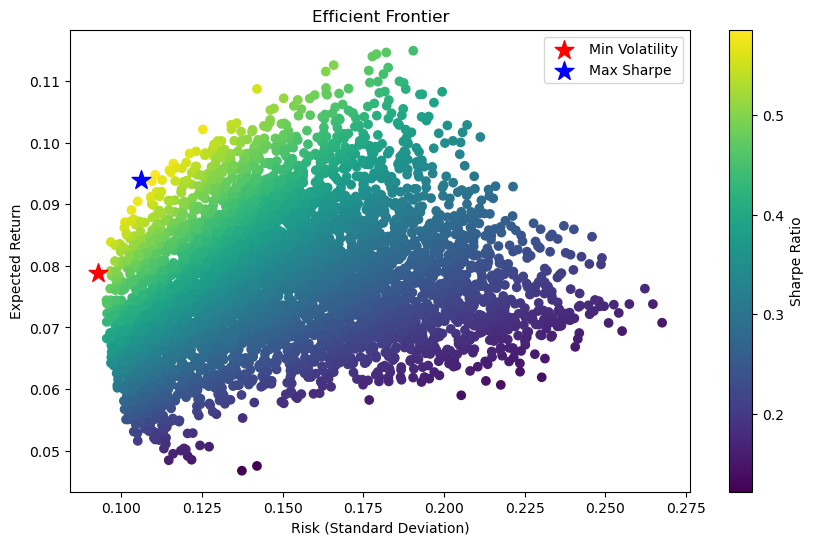

In [31]:
# Step 1-2: 효율적 프론티어
returns_list, std_list, sharpe_list = [], [], []
for _ in range(5000):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    p_return, p_std, p_sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    returns_list.append(p_return)
    std_list.append(p_std)
    sharpe_list.append(p_sharpe)

plt.figure(figsize=(10, 6))
plt.scatter(std_list, returns_list, c=sharpe_list, cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.scatter(*portfolio_performance(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)[1::-1],
            color='red', marker='*', s=200, label='Min Volatility')
plt.scatter(*portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)[1::-1],
            color='blue', marker='*', s=200, label='Max Sharpe')
plt.legend()
plt.show()

In [32]:
# Step 6: 결과 비교
print("Minimum Volatility Portfolio Weights:", min_vol_weights)
print("Maximum Sharpe Ratio Portfolio Weights:", max_sharpe_weights)
print("Risk Parity Portfolio Weights:", risk_parity_weights)
print("Maximum Diversification Portfolio Weights:", max_div_weights)

Minimum Volatility Portfolio Weights: [7.75791921e-18 1.92896189e-01 1.75110081e-17 3.33379324e-01
 4.73724487e-01]
Maximum Sharpe Ratio Portfolio Weights: [0.         0.31365256 0.         0.45046185 0.2358856 ]
Risk Parity Portfolio Weights: [0.13973271 0.22977709 0.16981978 0.20109836 0.25957205]
Maximum Diversification Portfolio Weights: [0.03904449 0.18081479 0.07492508 0.24467896 0.46053668]
